# 1. Finding Similar Costumers

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from collections import Counter

In [ ]:
customers_data = pd.read_csv('bank_transactions.csv', delimiter=',')

## Clean the Data Set

In [ ]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


Let's start with some basic exploration of the Data Set: we have 9 columns with and 1041614 rows. The first thing that we do, of course, is drop **NA** values. Moving forward, we can see that some of the rows are supposed to be of type **datetime**, but results in int or object: let's convert them.

In [ ]:
customers_data.dropna(inplace=True)

In [ ]:
customers_data.CustomerDOB = pd.to_datetime(customers_data.CustomerDOB)

In [ ]:
def convert_time(value):
    sec = str(value % 100)
    minutes = str((value //100) %100)
    hours = str((value // 10000) %100)
    return datetime.strptime(str(hours)+":"+str(minutes)+":"+str(sec), '%H:%M:%S').time()


In [ ]:
customers_data.TransactionTime = customers_data.TransactionTime.apply(lambda row: convert_time(row))

In [ ]:
customers_data.TransactionDate = pd.to_datetime(customers_data.TransactionDate)

Let's do some exploration of the column, starting from the date of birth of the costumers. From the histogram below, we see that there are some inconsistencies. In fact, it's not likely that there are some costumers born in 1800, but still alive. In the same way, it's not possible that we have some costumer that are less than 16 years old or that are yet to be born.  

In the first case, let's just drop the columns because there are really few entries and we just assume it was just dirty data.

In the second case, let's assume there was a erroneous offset of 100 years.

<AxesSubplot:>

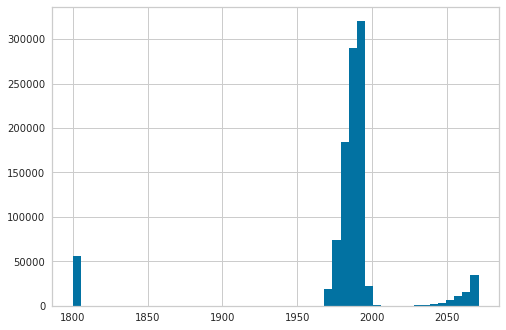

In [ ]:
customers_data.CustomerDOB.dt.year.hist(bins=50)

In [ ]:
customers_data.loc[customers_data.CustomerDOB.dt.year >2000, 'CustomerDOB'] = customers_data.loc[customers_data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [ ]:
customers_data.drop(customers_data[customers_data.CustomerDOB.dt.year == 1800].index, axis = 0, inplace=True)

Now that we fixed the Date of Birth column, we can add a new column based on it that gives us customer's age.

In [ ]:
customers_data['CustomerAge'] = (( pd.to_datetime('today') - customers_data.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
customers_data['CustomerAge'] = customers_data['CustomerAge'].astype(int)

Before adding new columns on which we are gonna calculate the minHash, let's just take a look at the Customer Identifier. We take, for example the customer with id 'C1010081'

In [ ]:
customers_data.loc[customers_data.loc[:, 'CustomerID'] =='C1010081']

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
113705,T113706,C1010081,1984-11-02,F,HOWRAH,17.71,2016-06-08,14:58:28,2856.0,38
329016,T329017,C1010081,1977-02-09,F,PANCHKULA,23319.04,2016-08-15,17:26:58,1699.0,46
347495,T347496,C1010081,1989-01-05,M,GHAZIABAD,1584.18,2016-08-14,14:47:42,429.0,34


As we can see above, the Customer ID makes absolutely no sense: this customer has, at the same time, three different dates of birth, two different genders, three different account balance and three different locations. We could justify the gender and the date of birth difference by assuming that two different people are using the same bank account, but even in this way, we can't explain the difference in balance and location.
Given that we can't rely on the pre-existing CustomerID, there are two assumptions that we can make:

- Every row is a different customer.
- A customer has to have the same CustomerDOB, CustGender, CustLocation and CustAccountBalance: one could argue that if two people use the same bank account they don't have to have the same date of birth or the same gender, but to that, I respond that, as we will see later on, the data manipulations we are gonna make are based on the behaviour of a single customer, not on the behaviour of the people that use the same account.

Both of the assumptions make sense and, at the same time, we can argue about both of them, but I'm gonna go with the second one because we can get more useful and interesting pieces of information if we assume that the second one is True.

## Create new columns

First of all, let's create a new ID. Like said before, our new id groups the customers by date of birth, account balance, location and geneder.
To do that, I create a dictionary of ID, where the key is the four information and the value is the new id. The new id has the form 'CUST'+progressive number.

In [ ]:
newIdsDict = {}
j=0
def createNewId(d):
    global j
    try:
        return newIdsDict[d['CustomerDOB'], d['CustAccountBalance'], d['CustLocation'], d['CustGender']] 
    except KeyError as e:
        newIdsDict[d['CustomerDOB'], d['CustAccountBalance'], d['CustLocation'], d['CustGender']] = 'CUST'+  str(j)
        j+=1
        return newIdsDict[d['CustomerDOB'], d['CustAccountBalance'], d['CustLocation'], d['CustGender']]     

Later, we will compute the Average Transaction Amount, meaning the average amount a customer spends on a single transaction. After getting this data, we will calculate the percentage, meaning how this average amount relates with the overall account balance.

In [ ]:
transactionPercentage = {}
def getTransactionPercentage(d):
    try:
        return transactionPercentage[d['MyCustomerID']] 
    except KeyError as e:
        safe_division = 0
        if(d['CustAccountBalance'] == 0):
            safe_division = 1
        transactionPercentage[d['MyCustomerID']] = (d['AverageTransactionAmount']*100)/(d['CustAccountBalance']+safe_division)
        return transactionPercentage[d['MyCustomerID']]     

In [ ]:
def extractMostTime(values):
    return Counter([0 if t < convert_time(193000) or t > convert_time(50000) else 1 for t in values]).most_common(1)[0][0]

In [ ]:
def extractMax(values):
    return Counter(list(values.dt.day_of_week)).most_common(1)[0][0]

In [ ]:
customers_data['MyCustomerID'] = customers_data.apply(createNewId, axis = 1)

To understand a customer's habits, we are interested in knowing which day of the week he spends more frequently. We can assume his personal habits based on this information: for example, if most transactions are made on the weekends, maybe he doesn't work on those days and goes out to spend on activities or stays home doing online shopping. Based on this, we could advise him on activities to do on the weekends or show him more ads on those days.
But if most transactions are made on the weekdays, maybe he works on the weekends or, even if he doesn't, he doesn't like spending his money on recreational activities or compulsive shopping. So, maybe suggesting recreational activities is not the best option.

In [ ]:
customers_data['MostFrequentDayOfWeek'] = customers_data.groupby('MyCustomerID')['TransactionDate'].transform(extractMax)

The most frequent time that transactions are made is another useful information. This new column contains a binary value: 0 if most transactions are made in the day and 1 if they are made at night. Based on the time most transactions are made, we can assume what the customer's interests are. For example, if he spends at night we can assume that he likes going out to bars/clubs/restaurants/other nights activities or that he stays home doing online shopping, maybe because he works in the mornings and afternoons.

In [ ]:
customers_data['MostFrequentTime'] = customers_data.groupby('MyCustomerID')['TransactionTime'].transform(extractMostTime)

We are interested in the average amount that a customer spends at every transaction because we are trying to understand a customer's economic behaviour. Similar customers will have similar behaviours and hence, will spend more or less the same amount.

In [ ]:
customers_data['AverageTransactionAmount'] = customers_data.groupby('MyCustomerID')['TransactionAmount (INR)'].transform('mean')

Other than the average transaction amount, we are interested in knowing how much the customer spend if releted on how much he has on his bank account. Since we are talking about credit card (and not debit), this percentage can be above 100, because a customer can make debts that he will pay later on. This is a really useful information, because it will tell us if a customer is likely to make debts to buy the thing he wants/needs or if he is willing to spend a large percentage of his account balance. In other words, this information will let us know if a client is thrifty or willing to do large expenses.

In [ ]:
customers_data['TransactionPercentage'] = customers_data.apply(getTransactionPercentage, axis = 1)

Other columns we are interested for the Min-Hash, of course:
- CustGender: the spending habits of a man and a woman can be different, hence this column will be considered for the Min-Hash.
- CustAccountBalance: of course, the balance that a customer has on his bank account it's fundamental to determinate the similarity with another customer.
- CustomerAge: the spending habits strongly depends on the customer's age. This is because people of different ages have different needs and, likely, different financial capacity.

In [ ]:
customers_data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge,MyCustomerID,MostFrequentDayOfWeek,MostFrequentTime,AverageTransactionAmount,TransactionPercentage
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0,28,CUST0,2,0,80.111111,0.449581
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.0,66,CUST1,0,0,9503.445000,418.526747
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0,26,CUST2,6,0,940.348182,5.260854
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0,49,CUST3,0,0,2537.346923,0.292826
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5,35,CUST4,0,0,1606.135000,23.920646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,18:48:24,799.0,32,CUST96608,1,0,965.050000,12.639502
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,18:37:34,460.0,31,CUST117231,6,0,449.000000,1.644001
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,18:33:13,770.0,34,CUST8450,5,0,1181.562500,0.532818
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,18:47:06,1000.0,44,CUST162310,6,0,1000.000000,9.883503


The Min-Hash below is formulated in this way:
- The first digit is based on the customer age
- The second digit is based on the average transaction amount
- The third digit is based on the customer's balance account
- The fourth digit is based on the customer's gender
- The last digit is based on the customer's percentage of the transaction amount calculated on the customer's balance account

The thresholds on which this minHash is calculated are dynamic: for this reason, it takes in input a dictionary of threshold. Of course, smaller the thresholds will be, the fewer collisions (hence similarities) we will get, but it will be more accurate.
On the other hand, bigger threshold will be, the more similarities we will obtain, but these similarities will be erroneous.
Hence, we have to find a trade-off between accuracy and the need to find similarities. 
After some sperimentations, here are my ideas.

In [ ]:
def minHash(d, threshold, minDict, maxDict):
    first_digit = -1
    counter = 0
    age = d['CustomerAge']

    for currAge in range(minDict['age'], maxDict['age']+threshold['age'],threshold['age']):
        if(age<=currAge):
            first_digit = counter
            break
        counter += 1
    
    transaction_avg_int = int(d['AverageTransactionAmount'])
    second_digit = len(str(transaction_avg_int))
    if(transaction_avg_int <= 10000):
        second_digit-=1
    if(transaction_avg_int >= 1000):
        if(int(str(transaction_avg_int)[0])>=6):
            second_digit+=1
    if(second_digit>9):
        second_digit = 9
    
    account_balance = int(d['CustAccountBalance'])
    third_digit = len(str(account_balance))
    if(account_balance <= 10000):
        third_digit -=1
    if(account_balance >=1000):
        if(int(str(account_balance)[0])>=6):
            third_digit+=1
    if(third_digit > 9):
        third_digit = 9
        
    sex = d.loc['CustGender']
    fourth_digit = ''
    if(sex == 'M'):
        fourth_digit = '0'
    elif(sex == 'F'):
        fourth_digit = '1'
        
    average_transaction_time = str(d.loc['MostFrequentTime']) ## Binary: 0 day, 1 night
        
    ## We transform this info in binary value: 0 if the most frequent day is a weekday, 1 otherwise
    most_frequent_day = '0'
    if (d.loc['MostFrequentDayOfWeek'] > 3):
        most_frequent_day = '1'
        
    # let's transform these two binary values in a binary number 
    fifth_digit = most_frequent_day+average_transaction_time
    fifth_digit = int(fifth_digit, 2) ## Transform the binary number into decimal, so that the output string is smaller

    percentage = int(d['TransactionPercentage'])
    sixth_digit = -1
    counter = 0
    for perc in range(minDict['TransactionPercentage'], 121,threshold['TransactionPercentage']):
        if(percentage<=perc):
            sixth_digit = counter
            break
        counter += 1
    if(sixth_digit <0):
        sixth_digit = counter


    hash_code = str(first_digit) + str(second_digit) + str(third_digit) + str(fourth_digit)  + str(fifth_digit) + str(sixth_digit)
    try:
        bins[hash_code].add(d['MyCustomerID'])
    except KeyError as e:
        bins[hash_code] = set([])
        bins[hash_code].add(d['MyCustomerID'])
        
    return hash_code

In [ ]:
minDict = {}
maxDict = {}
thresholdDict = {}

In [ ]:
minDict['CustAccountBalance'] = int(customers_data['CustAccountBalance'].min())
maxDict['CustAccountBalance'] = int(customers_data['CustAccountBalance'].max())+1
thresholdDict['CustAccountBalance'] = (maxDict['CustAccountBalance'] - minDict['CustAccountBalance'])//10

minDict['AverageTransactionAmount'] = int(customers_data['AverageTransactionAmount'].min())
maxDict['AverageTransactionAmount'] = int(customers_data['AverageTransactionAmount'].max())+1
thresholdDict['AverageTransactionAmount'] = (maxDict['AverageTransactionAmount'] - minDict['AverageTransactionAmount'])//10

minDict['TransactionPercentage'] = int(customers_data['TransactionPercentage'].min())
maxDict['TransactionPercentage'] = customers_data['TransactionPercentage'].max()
thresholdDict['TransactionPercentage'] = 15

minDict['age'] = customers_data['CustomerAge'].min()
maxDict['age'] = customers_data['CustomerAge'].max()
thresholdDict['age'] = (maxDict['age'] - minDict['age'])//13

In [ ]:
from tqdm import tqdm  
tqdm.pandas()

In [ ]:
bins = {}
customers_data['MinHashOutput'] = customers_data.progress_apply(minHash, args = (thresholdDict, minDict, maxDict), axis = 1)

100%|██████████| 985322/985322 [01:02<00:00, 15729.34it/s]


In [ ]:
customers_data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge,MyCustomerID,MostFrequentDayOfWeek,MostFrequentTime,AverageTransactionAmount,TransactionPercentage,MinHashOutput
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0,28,CUST0,2,0,80.111111,0.449581,115100
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.0,66,CUST1,0,0,9503.445000,418.526747,743009
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0,26,CUST2,6,0,940.348182,5.260854,125121
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0,49,CUST3,0,0,2537.346923,0.292826,437100
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5,35,CUST4,0,0,1606.135000,23.920646,234102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,18:48:24,799.0,32,CUST96608,1,0,965.050000,12.639502,224001
1048563,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,18:37:34,460.0,31,CUST117231,6,0,449.000000,1.644001,225021
1048564,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,18:33:13,770.0,34,CUST8450,5,0,1181.562500,0.532818,236020
1048565,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,18:47:06,1000.0,44,CUST162310,6,0,1000.000000,9.883503,435021


## Query Time

Now let's read the data from new customers that we are gonna compare with the previous ones.

In [ ]:
new_users = pd.read_csv('query_users.csv', delimiter=',')

The first thing we do is cleaning the data frame in the exact same way we did before, in order to have the same base situation.

In [ ]:
new_users.dropna(inplace=True)

In [ ]:
new_users.CustomerDOB = pd.to_datetime(new_users.CustomerDOB)

In [ ]:
new_users.TransactionDate = pd.to_datetime(new_users.TransactionDate)

In [ ]:
new_users.TransactionTime = new_users.TransactionTime.apply(lambda row: convert_time(row))

In [ ]:
new_users.loc[new_users.CustomerDOB.dt.year >2000, 'CustomerDOB'] = new_users.loc[new_users.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [ ]:
new_users.drop(new_users[new_users.CustomerDOB.dt.year == 1800].index, axis = 0, inplace=True)

In [ ]:
new_users['CustomerAge'] = (( pd.to_datetime('today') - new_users.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
new_users['CustomerAge'] = new_users['CustomerAge'].astype(int)

In [ ]:
newUsersId = {}
i=0
def createNewCustomersId(d):
    global i
    try:
        return newUsersId[d['CustomerDOB'], d['CustAccountBalance'], d['CustLocation'], d['CustGender']] 
    except KeyError as e:
        newUsersId[d['CustomerDOB'], d['CustAccountBalance'], d['CustLocation'], d['CustGender']] = 'QUERY_CUST'+  str(i)
        i+=1
        return newUsersId[d['CustomerDOB'], d['CustAccountBalance'], d['CustLocation'], d['CustGender']]     

In [ ]:
new_users['MyCustomerID'] = new_users.apply(createNewCustomersId, axis = 1)

In [ ]:
new_users['AverageTransactionAmount'] = new_users.groupby('MyCustomerID')['TransactionAmount (INR)'].transform('mean')

In [ ]:
new_users['TransactionPercentage'] = new_users.apply(getTransactionPercentage, axis = 1)

In [ ]:
new_users['MostFrequentDayOfWeek'] = new_users.groupby('MyCustomerID')['TransactionDate'].transform(extractMax)

In [ ]:
new_users['MostFrequentTime'] = new_users.groupby('MyCustomerID')['TransactionTime'].transform(extractMostTime)

Let's execute the min-hash on the query customers too

In [ ]:
new_users['MinHashOutput'] = new_users.apply(minHash, args = (thresholdDict, minDict, maxDict), axis = 1)

In [ ]:
new_users

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge,MyCustomerID,AverageTransactionAmount,TransactionPercentage,MostFrequentDayOfWeek,MostFrequentTime,MinHashOutput
0,1978-07-27,M,DELHI,94695.61,2016-02-09,14:03:10,65.00,44,QUERY_CUST0,65.00,0.068641,1,0,416000
1,1992-06-11,M,PANCHKULA,7584.09,2016-02-09,12:02:14,6025.00,31,QUERY_CUST1,6025.00,79.442623,1,0,244006
2,1991-08-14,M,PATNA,7180.60,2016-10-08,22:17:32,541.50,31,QUERY_CUST2,541.50,7.541153,5,0,224021
3,1987-03-01,M,CHENNAI,56847.75,2016-08-29,14:41:38,1000.00,36,QUERY_CUST3,1000.00,1.759085,0,0,235001
4,1995-04-01,M,GURGAON,84950.13,2016-09-25,23:33:09,80.00,28,QUERY_CUST4,80.00,0.094173,6,0,116020
5,1981-10-01,M,WORLD TRADE CENTRE BANGALORE,23143.95,2016-11-09,19:29:06,303.00,41,QUERY_CUST5,303.00,1.309197,2,0,325001
6,1976-09-20,F,CHITTOOR,15397.80,2016-08-28,09:26:33,20.00,46,QUERY_CUST6,20.00,0.129889,6,0,415120
7,1991-10-04,M,MOHALI,426.30,2016-02-08,20:37:54,50.00,31,QUERY_CUST7,50.00,11.728829,0,0,212001
8,1990-03-19,M,MOHALI,4609.34,2016-08-26,18:40:15,300.00,33,QUERY_CUST8,300.00,6.508524,4,0,223021
9,1970-12-19,M,SERAMPORE,6695988.46,2016-08-27,14:40:30,299.00,52,QUERY_CUST9,299.00,0.004465,5,0,528020


Now let's take a look to the final results:

In [ ]:
pd.DataFrame(list(bins.items()), columns = ['Signature', 'CustomerID'])

,Signature,CustomerID
0,115100,"{CUST42490, CUST0, CUST139040, CUST124875, CUS..."
1,743009,"{CUST130868, CUST81696, CUST1}"
2,125121,"{CUST5598, CUST2, CUST23419, CUST67542, CUST23..."
3,437100,"{CUST18721, CUST4552, CUST64385, CUST17438, CU..."
4,234102,"{CUST90072, CUST92980, CUST32168, CUST35171, C..."
...,...,...
3663,1425121,{CUST162148}
3664,1336021,{CUST162220}
3665,152129,{CUST162223}
3666,466125,{CUST162284}


In [ ]:
customers_data = customers_data.drop_duplicates(subset=['MyCustomerID'])

In [ ]:
customers_data.loc[customers_data.loc[:,'MinHashOutput'] == '213000']

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge,MyCustomerID,MostFrequentDayOfWeek,MostFrequentTime,AverageTransactionAmount,TransactionPercentage,MinHashOutput
4252,T4253,C3218492,1988-08-20,M,NIZAMABAD,4413.71,2016-09-22,09:15:56,14.0,34,CUST3661,1,0,32.928571,0.746052,213000
4618,T4619,C7118336,1991-10-05,M,KOLHAPUR,5701.20,2016-09-22,14:12:57,10.0,31,CUST3977,3,0,20.000000,0.350803,213000
4684,T4685,C8919258,1990-05-08,M,HISAR,5887.94,2016-09-22,15:52:35,48.0,33,CUST4033,3,0,34.000000,0.577452,213000
5828,T5829,C8829833,1990-02-20,M,MUMBAI,5591.99,2016-09-22,15:37:14,10.0,33,CUST4977,3,0,10.000000,0.178827,213000
8830,T8831,C3915092,1991-07-12,M,BANGALORE,4284.96,2016-09-25,20:08:09,58.0,31,CUST7422,2,0,42.818182,0.999267,213000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935007,T935008,C1532748,1987-03-28,M,ALMORA,2184.87,2016-11-09,17:49:41,20.0,36,CUST155590,2,0,20.000000,0.915386,213000
940571,T940572,C6434721,1988-01-28,M,CHENNAI,5065.02,2016-11-09,23:16:20,30.0,35,CUST156015,2,0,30.000000,0.592298,213000
980712,T980713,C4431860,1987-05-03,M,RAIGARH CG RAIGARH,5377.39,2016-09-15,11:37:40,50.0,36,CUST158425,3,0,50.000000,0.929819,213000
988055,T988056,C7123539,1992-09-09,M,CHANDIGARH,2022.83,2016-09-15,23:41:01,17.0,30,CUST158881,3,0,17.000000,0.840407,213000


In [ ]:
new_users.loc[new_users.loc[:,'MinHashOutput'] == '213000']

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge,MyCustomerID,AverageTransactionAmount,TransactionPercentage,MostFrequentDayOfWeek,MostFrequentTime,MinHashOutput
40,1987-02-18,M,CHENNAI,2887.39,2016-08-24,18:17:03,20.0,36,QUERY_CUST36,20.0,0.692667,2,0,213000


As we can see from the results, all costumers in bin **'325001'**:
- Usually do the most transactions in the day time rather than the night time.
- Do the most transactions in the week days.
- On average, the percentage of their transactions on the account balance is less than 1%.
- The average transaction amount is more than 10 euros, but less 60 euros.
- Their age is between 30 and 36 years.
- They are all men.
- Their account balance is between 1.100 and 6.000 euros.
Of course our threshold is pretty big, such that we found in single bin 150 customers. To make the bins less full, we could add more filters such as number of transactions or the distance between customer's locations. We could also calculate other statistic as medians or quantiles.
Nevertheless, this seems already a pretty good result.

# 2 Grouping customers together!

## 2.1 Getting your data + feature engineering

In [ ]:
#Some useful library
import pandas as pd
import statistics
import numpy as np

In [ ]:
#I read the csv file
data = pd.read_csv('bank_transactions.csv')

In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [ ]:
#I delete all the rows of the dataframe which contain NA values
data.dropna(inplace=True) 

In [ ]:
#I am changing the format of the date of birth and the date of the transaction
#to make it clearer
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)
data.TransactionDate = pd.to_datetime(data.TransactionDate)

In [ ]:
def zeros(x):
    l = len(x)
    if l != 6:
        x = '0' * (6-l) + x
        
    return x

In [ ]:
#I change the time format in TransactionTime
data.TransactionTime = list(map(str,data.TransactionTime))
data.TransactionTime = list(map(zeros,data.TransactionTime))
data.TransactionTime = data.TransactionTime.apply(lambda x: f'{x[:2]}:{x[2:4]}:{x[4:]}')
data.TransactionTime = pd.to_datetime(data.TransactionTime, format='%H:%M:%S')
data.TransactionTime = pd.to_datetime(data.TransactionTime).dt.time

In [ ]:
#Customers born after 2000 are considered born 100 years earlier
#I drop out the customers born in 1800 from the dataset
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

Matplotlib is building the font cache; this may take a moment.


<AxesSubplot:>

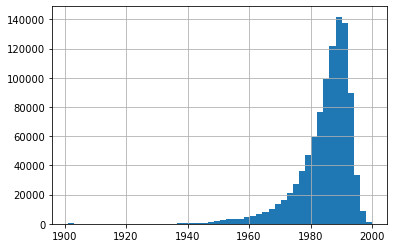

In [ ]:
data.CustomerDOB.dt.year.hist(bins=50)

In [ ]:
#I sort the dataset with respect to the columns 'TransactionDate' and 'TransactionTime'
data.sort_values(by=['TransactionDate', 'TransactionTime'], inplace = True)

In [ ]:
#I add four columns to the dataframe
#The first one contains the age of the customers
data['CustomerAge'] = ((pd.to_datetime('today') - data.CustomerDOB) / np.timedelta64(1, 'Y')).round(0)
data['CustomerAge'] = data['CustomerAge'].astype(int)
#The second one contains the utilisation
data['Utilisation'] = data['CustAccountBalance'] - data['TransactionAmount (INR)']
#The third one contains the month of the transaction
data['Month_of_Transaction']=data.TransactionDate.dt.month
#The fourth one contains the day of the transaction
data['Day_of_Transaction']=data.TransactionDate.dt.day

In [ ]:
#I create a new dataframe where I'm going to insert the new features
data_customer = pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
#Group data by clients (using CustomerId)
dt_customer=data.groupby('CustomerID')

I group data by the client (using CustomerId) and I create the following new features for each CustomerId:

a) Number of transactions

b) Number of transactions with a balance bigger than 100

c) Average amount of the transactions

d) Average balance

e) Average utilisation

f) Most common gender of the customer

h) Most frequent location of the customer

In [ ]:
#Number of transactions
data_customer['Number_of_transactions'] = dt_customer.TransactionID.count()
#Number of transactions with a balance bigger than 100
data_customer['Numb_trans>100'] = dt_customer['TransactionAmount (INR)'].apply(lambda x: (x>100).sum())
#Average amount of the transactions
data_customer['Average_of_transactions'] = dt_customer['TransactionAmount (INR)'].mean().round(2)
#Average balance
data_customer['Average_balance'] = dt_customer['CustAccountBalance'].mean().round(2)
#Average utilisation
data_customer['Utilisation'] = dt_customer['Utilisation'].mean().round(2)
#Most common gender
data_customer['Gender'] = dt_customer.CustGender.agg(statistics.mode)
#Most frequent location
data_customer['Location'] = dt_customer.CustLocation.agg(statistics.mode)

In [ ]:
data_customer.head()

,Number_of_transactions,Numb_trans>100,Average_of_transactions,Average_balance,Utilisation,Gender,Location
CustomerID,,,,,,,
C1010011,2,2,2553.0,76340.63,73787.63,M,NEW DELHI
C1010012,1,1,1499.0,24204.49,22705.49,M,MUMBAI
C1010014,2,2,727.5,100112.95,99385.45,F,MUMBAI
C1010018,1,0,30.0,496.18,466.18,F,CHAMPARAN
C1010024,1,1,5000.0,87058.65,82058.65,M,KOLKATA


### Additional features

For each customerID I add the maximum and the minimum amount of the transactions and the maximum and minimum account balance. It can be useful to have information on the maximum and minimum transaction amount of each customerID and the maximum and minimum account balance of each customerID.

In [ ]:
data_customer['Max_Transaction_Amount'] = dt_customer['TransactionAmount (INR)'].max()
data_customer['Min_Transaction_Amount'] = dt_customer['TransactionAmount (INR)'].min()
data_customer['Max_Account_Balance'] = dt_customer['CustAccountBalance'].max()
data_customer['Min_Account_Balance'] = dt_customer['CustAccountBalance'].min()

For each customerID I add the average age, the number of people (with that custumerID) over the age of 60, under the age of 18, between the ages of 18 and 60. It can be useful to understand how many young people and how many elderly people make transactions with the same custumerID.

In [ ]:
data_customer['Average_Age'] = dt_customer['CustomerAge'].mean().round(2)

In [ ]:
data_customer['Age>60'] = dt_customer['CustomerAge'].apply(lambda x: (x>60).sum())

In [ ]:
data_customer['Age<18'] = dt_customer['CustomerAge'].apply(lambda x: (x<18).sum())

In [ ]:
data_customer['18<Age<60'] = dt_customer['CustomerAge'].apply(lambda x: ((x>18) & (x<60)).sum())

For each customerID I add the number of women with that custumerID. It can be useful to understand how many women make transactions with the same custumerID.

In [ ]:
data_customer['Number_of_women'] = dt_customer['CustGender'].apply(lambda x: (x == 'F').sum())

For each customerID I add the location of the first and the last transaction and the date of the first and the last transaction. It can be useful to understand how long the custumerID has been active and where the transactions are made.

In [ ]:
data_customer['First_Location'] = dt_customer.CustLocation.first()
data_customer['Last_Location'] = dt_customer.CustLocation.last()
data_customer['First_Transaction'] = dt_customer.TransactionDate.first()
data_customer['Last_Transaction'] = dt_customer.TransactionDate.last()

For each customerID I use the quantile function to add the number of transactions with an high amount and a low amount. 

In [ ]:
h_t=data['TransactionAmount (INR)'].quantile(0.8)
l_t=data['TransactionAmount (INR)'].quantile(0.2)

In [ ]:
data_customer['Number_of_high_transactions'] = dt_customer['TransactionAmount (INR)'].apply(lambda x: (x>h_t).sum())
data_customer['Number_of_low_transactions'] = dt_customer['TransactionAmount (INR)'].apply(lambda x: (x<l_t).sum())

For each customerID I use the quantile function to add the number of account balance with an high account balance and a low account balance. It can be useful to understand who is 'rich' or 'poor'

In [ ]:
h_ab=data['CustAccountBalance'].quantile(0.8)
l_ab=data['CustAccountBalance'].quantile(0.2)

In [ ]:
data_customer['Number_of_high_AccountBalance'] = dt_customer['CustAccountBalance'].apply(lambda x: (x>h_ab).sum())
data_customer['Number_of_low_AccountBalance'] = dt_customer['CustAccountBalance'].apply(lambda x: (x<l_ab).sum())

For each customerID I add the most common month and the most common day in which transactions are made. It can be useful to have an idea of the period in which that custumerID is most active.

In [ ]:
data_customer['Most_common_month'] = dt_customer.Month_of_Transaction.agg(statistics.mode)
data_customer['Most_common_day'] = dt_customer.Day_of_Transaction.agg(statistics.mode)

For each customerID I add the number of days that passed between the first and last transaction.

In [ ]:
data_customer['Day_from_first to_last_trans'] = (data_customer['Last_Transaction'] - data_customer['First_Transaction']).dt.days

In [ ]:
data_customer.head()

,Number_of_transactions,Numb_trans>100,Average_of_transactions,Average_balance,Utilisation,Gender,Location,Max_Transaction_Amount,Min_Transaction_Amount,Max_Account_Balance,...,Last_Location,First_Transaction,Last_Transaction,Number_of_high_transactions,Number_of_low_transactions,Number_of_high_AccountBalance,Number_of_low_AccountBalance,Most_common_month,Most_common_day,Day_from_first to_last_trans
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2,2,2553.0,76340.63,73787.63,M,NEW DELHI,4750.0,356.0,120180.54,...,NOIDA,2016-09-08,2016-09-26,1,0,1,0,9,8,18
C1010012,1,1,1499.0,24204.49,22705.49,M,MUMBAI,1499.0,1499.0,24204.49,...,MUMBAI,2016-08-14,2016-08-14,0,0,0,0,8,14,0
C1010014,2,2,727.5,100112.95,99385.45,F,MUMBAI,1205.0,250.0,161848.76,...,MUMBAI,2016-01-08,2016-07-08,0,0,1,0,1,8,182
C1010018,1,0,30.0,496.18,466.18,F,CHAMPARAN,30.0,30.0,496.18,...,CHAMPARAN,2016-09-15,2016-09-15,0,1,0,1,9,15,0
C1010024,1,1,5000.0,87058.65,82058.65,M,KOLKATA,5000.0,5000.0,87058.65,...,KOLKATA,2016-08-18,2016-08-18,1,0,1,0,8,18,0


In [ ]:
data_customer.to_csv('bank_transactions2.csv')

## 2.2 Choose your features (variables)!

In [ ]:
data_bt2 = pd.read_csv('bank_transactions2.csv', sep=',')

In [ ]:
data_bt2.head()

,CustomerID,Number_of_transactions,Numb_trans>100,Average_of_transactions,Average_balance,Utilisation,Gender,Location,Max_Transaction_Amount,Min_Transaction_Amount,...,Last_Location,First_Transaction,Last_Transaction,Number_of_high_transactions,Number_of_low_transactions,Number_of_high_AccountBalance,Number_of_low_AccountBalance,Most_common_month,Most_common_day,Day_from_first to_last_trans
0,C1010011,2,2,2553.0,76340.63,73787.63,M,NEW DELHI,4750.0,356.0,...,NOIDA,2016-09-08,2016-09-26,1,0,1,0,9,8,18
1,C1010012,1,1,1499.0,24204.49,22705.49,M,MUMBAI,1499.0,1499.0,...,MUMBAI,2016-08-14,2016-08-14,0,0,0,0,8,14,0
2,C1010014,2,2,727.5,100112.95,99385.45,F,MUMBAI,1205.0,250.0,...,MUMBAI,2016-01-08,2016-07-08,0,0,1,0,1,8,182
3,C1010018,1,0,30.0,496.18,466.18,F,CHAMPARAN,30.0,30.0,...,CHAMPARAN,2016-09-15,2016-09-15,0,1,0,1,9,15,0
4,C1010024,1,1,5000.0,87058.65,82058.65,M,KOLKATA,5000.0,5000.0,...,KOLKATA,2016-08-18,2016-08-18,1,0,1,0,8,18,0


In [ ]:
data_bt2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CustomerID                     839081 non-null  object 
 1   Number_of_transactions         839081 non-null  int64  
 2   Numb_trans>100                 839081 non-null  int64  
 3   Average_of_transactions        839081 non-null  float64
 4   Average_balance                839081 non-null  float64
 5   Utilisation                    839081 non-null  float64
 6   Gender                         839081 non-null  object 
 7   Location                       839081 non-null  object 
 8   Max_Transaction_Amount         839081 non-null  float64
 9   Min_Transaction_Amount         839081 non-null  float64
 10  Max_Account_Balance            839081 non-null  float64
 11  Min_Account_Balance            839081 non-null  float64
 12  Average_Age                   

### 2.2.1 To normalise or not to normalise? That's the question. 
### Sometimes it is worth normalising (scaling) the features. Explain if it is a good idea to perform any normalisation method. If you think the normalisation should be used, apply it to your data (look at the available normalisation functions in the scikit-learn library).

The Z-score normalization,also called standardization, is a very important preprocessing step which rescales features such that they have a standard gaussian distribution shape (with a mean of zero and a standard deviation of one) and properties. Standardizing means bringing variables to the same scale so that it is possible to compare values of the respective frequency distribution regardless of the order of magnitude and dispersion. <br> In our case, standardization is fundamental to perform dimentionality reduction with PCA because the interest is in finding the components that maximise the variance. To catch these components we need to be able to compare their variability and that is the reason why variables must be scaled. 

In [ ]:
from sklearn import preprocessing

In [ ]:
#From the dataframe with all the features created, we keep only the variables we want to standardize and take into account to perform the PCA
data1 = pd.read_csv('bank_transactions2.csv', sep=',', usecols=['Number_of_transactions', 'Numb_trans>100', 'Average_of_transactions',
                                                                                           'Average_balance', 'Utilisation', 'Max_Transaction_Amount',
                                                                                           'Min_Transaction_Amount', 'Max_Account_Balance', 
                                                                                           'Min_Account_Balance', 
                                                                                           '18<Age<60',
                                                                                           'Number_of_high_transactions', 'Number_of_low_transactions',
                                                                                           'Number_of_high_AccountBalance', 'Number_of_low_AccountBalance'
                                                                                           ])

In [ ]:
round(data1.corr(), 3) 

,Number_of_transactions,Numb_trans>100,Average_of_transactions,Average_balance,Utilisation,Max_Transaction_Amount,Min_Transaction_Amount,Max_Account_Balance,Min_Account_Balance,18<Age<60,Number_of_high_transactions,Number_of_low_transactions,Number_of_high_AccountBalance,Number_of_low_AccountBalance
Number_of_transactions,1.000,0.628,-0.001,0.001,0.001,0.068,-0.065,0.043,-0.040,0.912,0.196,0.200,0.197,0.198
Numb_trans>100,0.628,1.000,0.082,0.025,0.025,0.124,0.037,0.053,-0.002,0.560,0.312,-0.629,0.223,0.017
Average_of_transactions,-0.001,0.082,1.000,0.055,0.047,0.968,0.970,0.054,0.051,-0.022,0.312,-0.104,0.095,-0.044
Average_balance,0.001,0.025,0.055,1.000,1.000,0.056,0.050,0.965,0.960,-0.032,0.067,-0.032,0.205,-0.060
Utilisation,0.001,0.025,0.047,1.000,1.000,0.048,0.043,0.965,0.960,-0.032,0.065,-0.031,0.205,-0.060
Max_Transaction_Amount,0.068,0.124,0.968,0.056,0.048,1.000,0.882,0.063,0.044,0.040,0.335,-0.090,0.112,-0.032
Min_Transaction_Amount,-0.065,0.037,0.970,0.050,0.043,0.882,1.000,0.042,0.054,-0.078,0.270,-0.111,0.073,-0.053
Max_Account_Balance,0.043,0.053,0.054,0.965,0.965,0.063,0.042,1.000,0.856,0.005,0.077,-0.024,0.218,-0.052
Min_Account_Balance,-0.040,-0.002,0.051,0.960,0.960,0.044,0.054,0.856,1.000,-0.066,0.052,-0.037,0.178,-0.064
18<Age<60,0.912,0.560,-0.022,-0.032,-0.032,0.040,-0.078,0.005,-0.066,1.000,0.146,0.199,0.138,0.195


In [ ]:
#Be sure there are no NaN values 
data1.isnull().sum()

Number_of_transactions           0
Numb_trans>100                   0
Average_of_transactions          0
Average_balance                  0
Utilisation                      0
Max_Transaction_Amount           0
Min_Transaction_Amount           0
Max_Account_Balance              0
Min_Account_Balance              0
18<Age<60                        0
Number_of_high_transactions      0
Number_of_low_transactions       0
Number_of_high_AccountBalance    0
Number_of_low_AccountBalance     0
dtype: int64

In [ ]:
#Make a copy of the dataset to work with
data1_c = data1.copy()

In [ ]:
#Define a variable with all the infos to preprocess
scaler = preprocessing.StandardScaler().fit(data1_c)

In [ ]:
#Mean for each column before standardization
scaler.mean_

array([1.17428711e+00, 9.43233132e-01, 1.45362357e+03, 1.05854539e+05,
       1.04400916e+05, 1.63693173e+03, 1.28590562e+03, 1.21177052e+05,
       9.19485100e+04, 1.13727519e+00, 2.34274164e-01, 2.34668643e-01,
       2.34853369e-01, 2.34841452e-01])

In [ ]:
#Standard deviation for each column before standardization
scaler.scale_

array([4.35128716e-01, 5.54211529e-01, 6.04519607e+03, 7.86251892e+05,
       7.85944175e+05, 6.62770610e+03, 5.88438086e+03, 8.80467172e+05,
       7.56134728e+05, 4.61951182e-01, 4.41779298e-01, 4.42614493e-01,
       4.42644412e-01, 4.42809557e-01])

In [ ]:
#Standardize the whole dataset
data1_scaled = scaler.transform(data1_c)
data1_scaled

array([[ 1.89762905,  1.90679337,  0.18185952, ..., -0.53018744,
         1.7285808 , -0.53034414],
       [-0.4005415 ,  0.10242816,  0.0075062 , ..., -0.53018744,
        -0.53056892, -0.53034414],
       [ 1.89762905,  1.90679337, -0.1201158 , ..., -0.53018744,
         1.7285808 , -0.53034414],
       ...,
       [-0.4005415 ,  0.10242816, -0.2196163 , ..., -0.53018744,
        -0.53056892, -0.53034414],
       [-0.4005415 , -1.70193705, -0.23218826, ...,  1.72911499,
        -0.53056892, -0.53034414],
       [-0.4005415 ,  0.10242816, -0.09902467, ..., -0.53018744,
        -0.53056892, -0.53034414]])

In [ ]:
#Check if the mean of the standardize dataset is 0
round(data1_scaled.mean(),3)

0.0

In [ ]:
#Check if the standard deviation of the standardize dataset is 1
round(data1_scaled.std(),3)

1.0

### 2.2.2 Select one method for dimensionality reduction and apply it to your data. 
### Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

In [ ]:
pip install pca

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

PCA (Principal Component Analysis) is a statistical method to perform dimentionality reduction useful to save storage and reduce computational time which results in a more efficient work of algorithms. It uses orthogonal transformation to turn observations of correlated featurs into a set of linearly uncorrelated data. <br> While dealing with a large number of variables, it might be useful to select a subset of them that are responsable for as much information of the original dataset. These are the principal components which are extracted in the way that the initial component explains maximum variance in the dataset, the second, which is unrelated to the first one, explains the remaining, the third explains the variance that the previous two didn't and so on until the wanted percentage of the total variance explained is reached (usually al least 70%). <br> PCA might have some limitations such as:
*   It assumes a correlation between features.
*   It is sensitive to the scale of the features which is why we normalize/standardize variables.
*   It is not robust against outliers.
*   It assumes a linear relationship between features which is not always verified.

In [ ]:
#Setup the PCA such that the explained variance is at least 70%
pca = PCA(.70)

In [ ]:
#Calculate the principal components 
principalComponents = pca.fit_transform(data1_scaled)

In [ ]:
principalComponents

array([[ 0.71908544,  1.9445513 , -3.25156931, -0.99525909],
       [-0.2742732 , -0.12152796,  0.56117515, -0.58653129],
       [ 0.40366608,  0.87451155, -3.15389646, -0.72853308],
       ...,
       [-0.41168093, -0.43397294,  0.42456348, -0.68394322],
       [-0.61144017, -1.18496069,  1.23697239,  1.55249492],
       [-0.35875383, -0.26173065,  0.49725992, -0.63386797]])

In [ ]:
#See how much of the total variance is explained by each principal component 
pca.explained_variance_ratio_ * 100

array([28.56454433, 21.93428476, 18.14941145, 11.2598817 ])

#### 2.2.3 Apply the selected method(s) to your data. Ensure the chosen method retains > 70% of the total variance.

In [ ]:
#Create a dataframe with all the principal components 
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2', 'PC 3','PC 4']) 

In [ ]:
principalDf.head()

,PC 1,PC 2,PC 3,PC 4
0,0.719085,1.944551,-3.251569,-0.995259
1,-0.274273,-0.121528,0.561175,-0.586531
2,0.403666,0.874512,-3.153896,-0.728533
3,-0.823423,-1.190655,0.921144,2.417501
4,0.722490,1.495663,0.317788,-1.154908


In [ ]:
#Save the dataframe with the PCs in a csv file to make it easier to use
principalDf.to_csv('PCs.csv')

In [ ]:
#Look at the correlation between the principal components 
round(principalDf.corr(), 3) #as we expected, the principal components are uncorrelated between them 

,PC 1,PC 2,PC 3,PC 4
PC 1,1.0,-0.0,-0.0,-0.0
PC 2,-0.0,1.0,0.0,0.0
PC 3,-0.0,0.0,1.0,-0.0
PC 4,-0.0,0.0,-0.0,1.0


In [ ]:
#percentage of the total variance explained by the 4 principal components 
total_var = pca.explained_variance_ratio_.sum() * 100
total_var

79.90812223735725

**Let's see two ways to visualize the first 3 principal components (which explain the 68.64% of the total variance)**

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [14] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


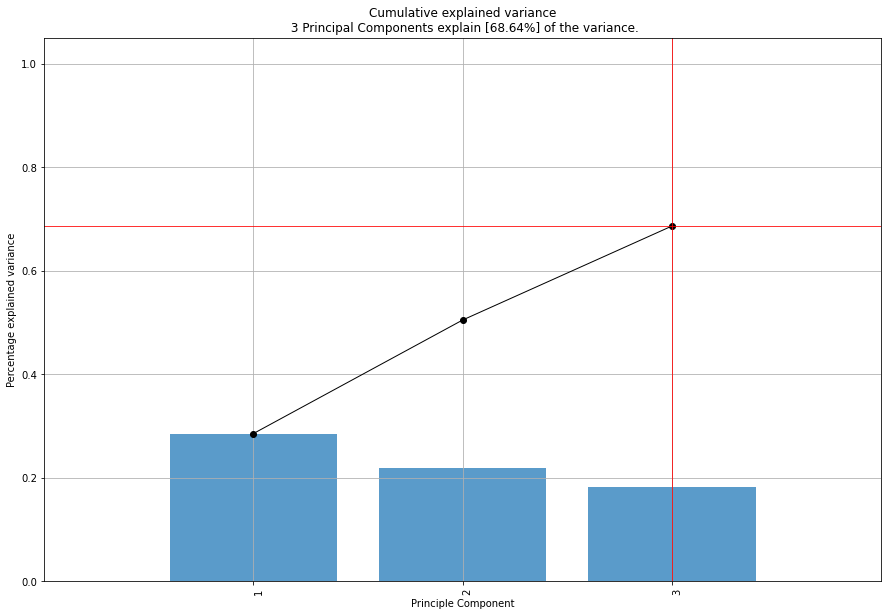

<Figure size 432x288 with 0 Axes>

In [ ]:
# Perform the PCA with just 3 components
from pca import pca 
model = pca(n_components=3)
results = model.fit_transform(data1_scaled)

# Plot explained variance
fig, ax = model.plot()

This plot shows the percentage of the total variance explained by each of the first three principal components. The first one explaines almost the 30% of the total variance, the second  one more than 20% and the third one almost 20%, for a total of 68.64% of the total variance explained by three independent components

[pca] >Plot PC1 vs PC2 with loadings.


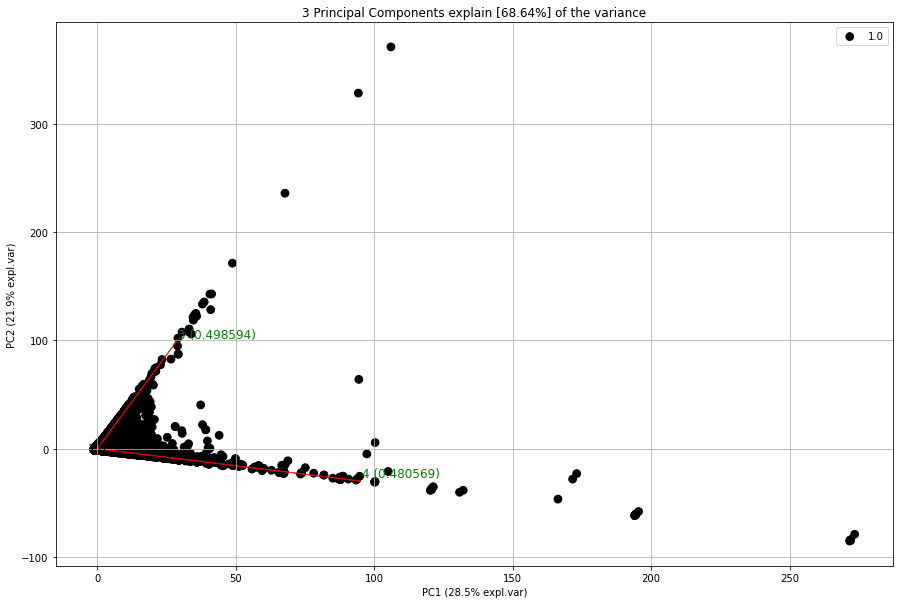

In [ ]:
#Make biplot with the number of features
fig, ax = model.biplot(n_feat=2)

Biplot is a way to visualize PC scores as dots and lodings of variables as vectors. The further away these vectors are from a PC origin, the more influence they have on that PC.

## 2.3 Clustering! 

In [ ]:
pip install yellowbrick

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.style as style
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import pyspark 
from pyspark.sql import SparkSession
from pyspark.rdd import RDD
import warnings
warnings.filterwarnings("ignore")
spark = SparkSession.builder.appName("CsvReader").getOrCreate()

### 2.3.1 K-Means

In [ ]:
data_pcs = spark.read.format("csv").option("header", "true").load("PCs.csv")
data_pcs.head(2)
print(data_pcs.columns)

22/12/11 18:28:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , PC 1, PC 2, PC 3, PC 4
 Schema: _c0, PC 1, PC 2, PC 3, PC 4
Expected: _c0 but found: 
CSV file: file:///home/ec2-user/SageMaker/PCs.csv
['_c0', 'PC 1', 'PC 2', 'PC 3', 'PC 4']


Even tough there are four PCs, we will only consider the first three

In [ ]:
data_pcs = data_pcs.withColumn("PC 1",data_pcs['PC 1'].cast('float'))
data_pcs = data_pcs.withColumn("PC 2",data_pcs['PC 2'].cast('float'))
data_pcs = data_pcs.withColumn("PC 3",data_pcs['PC 3'].cast('float'))
data_pcs = data_pcs.withColumn("PC 4",data_pcs['PC 4'].cast('float'))

In [ ]:
data_rdd = data_pcs.rdd

Function for randomic generation of centroids from the dataset of PCs

In [ ]:
def init_centroids(dataset, k):
    initial_centroids = dataset.takeSample(False, k)
    
    #Let's just take the numeric values and discard the rest
    arr = np.array([i[1:-1] for i in initial_centroids])

    return arr

Function for computing distance between two points

In [ ]:
def distance(p1, p2):
    distance = (p1[0]-p2[0])*(p1[0]-p2[0])+(p1[1]-p2[1])*(p1[1]-p2[1])+(p1[2]-p2[2])*(p1[2]-p2[2])
    return distance

Function that assigns to every point the centroids at the shortest distance

In [ ]:
def assign_centroids(p, centroids):
    min_dist = float("inf")
    nearest_centroid = 0
    for i in range(len(centroids)):
        distance_output = distance(centroids[i], p)
        if(distance_output < min_dist):
            min_dist = distance_output
            nearest_centroid = i
    return nearest_centroid

Once we sum all the points in a cluster, we will calculate the average point with this function

In [ ]:
def get_average_point(x):
        n_points  = float(x[3])
        x_point = x[0]/n_points
        y_point = x[1]/n_points
        z_point = x[2]/n_points
        return [x_point, y_point, z_point, n_points]

The stopping criterion for the k-means algorithm is that our new centroids have distance from the old ones less or equal than threshold. That's because if this condition happens, if we continued there would be (almost) no improvement.

In [ ]:
def stopping_criterion(old_centroids, new_centroids, threshold):
    for i in range(0, len(old_centroids)):
        check = distance(old_centroids[i], new_centroids[i]) <= threshold
        if check == False:
            return False
    return True

This is how the rows of our new Data Set look like

In [ ]:
data_rdd.take(5)

22/12/11 18:26:55 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , PC 1, PC 2, PC 3, PC 4
 Schema: _c0, PC 1, PC 2, PC 3, PC 4
Expected: _c0 but found: 
CSV file: file:///home/ec2-user/SageMaker/PCs.csv


[Row(_c0='0', PC 1=0.7190854549407959, PC 2=1.9445513486862183, PC 3=-3.2515692710876465, PC 4=-0.9952591061592102),
 Row(_c0='1', PC 1=-0.27427318692207336, PC 2=-0.12152795493602753, PC 3=0.5611751675605774, PC 4=-0.5865312814712524),
 Row(_c0='2', PC 1=0.40366607904434204, PC 2=0.8745115399360657, PC 3=-3.1538965702056885, PC 4=-0.7285330891609192),
 Row(_c0='3', PC 1=-0.8234232068061829, PC 2=-1.19065523147583, PC 3=0.9211443066596985, PC 4=2.4175007343292236),
 Row(_c0='4', PC 1=0.7224903106689453, PC 2=1.4956629276275635, PC 3=0.31778818368911743, PC 4=-1.1549084186553955)]

In [ ]:
initial_centroids = init_centroids(data_rdd, 4)
old_centroids = initial_centroids

22/12/11 18:37:08 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , PC 1, PC 2, PC 3, PC 4
 Schema: _c0, PC 1, PC 2, PC 3, PC 4
Expected: _c0 but found: 
CSV file: file:///home/ec2-user/SageMaker/PCs.csv


22/12/11 18:37:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , PC 1, PC 2, PC 3, PC 4
 Schema: _c0, PC 1, PC 2, PC 3, PC 4
Expected: _c0 but found: 
CSV file: file:///home/ec2-user/SageMaker/PCs.csv


And these are our **random generated initial centroids**

In [ ]:
initial_centroids

array([[ 0.67270434,  3.17225075, -2.81376171],
       [ 0.45510039, -0.29358998,  0.11905827],
       [ 0.41310859, -0.05029744,  0.20837055],
       [-0.48462284, -0.11566369, -2.04390669]])

In [ ]:
# row[1:3] because we only need the points in order to compute distances (and hence, assign centroids)
# The result of our mapping will be: key = centroid assigned, value = points, number of points in the row (always 1)
cluster_assignment_rdd = data_rdd.map(lambda row: (assign_centroids(row[1:-1], initial_centroids), np.array([row['PC 1'], row['PC 2'], row['PC 3'], 1])))

**K-means algorithm:**
The k-means algorithm is a method for clustering a set of data points into a specified number of clusters, based on the similarity of the data points. 
The algorithm tries to minimize the distance between the data points in each cluster and the centroid of that cluster. This is done by iteratively assigning each data point to the cluster with the closest centroid, and then recalculating the centroids based on the data points in each cluster. The process continues until the maximum number of iterations have been reached or the distances between old and new centroids are less or equal than a certain (small) threshold. 

We implemented the algorithm below in this way:
- Initialize the centroids for the clusters randomly.
- Iterate until the centroids do not change:
- Assign each data point to the cluster with the closest centroid.
- Calculate the new centroids for each cluster based on the data points assigned to it.
- Repeate the last two steps until the centroids (almost) do not change or a the max number of iterations have been reached.

In [ ]:
maxiterations = 10000 #ten thousand
threshold = 1 ## the algorithm will stop if the new centroids are at distance 0.00001 or lower from the previous ones
n = 0
while True:
        cluster_assignment_rdd = data_rdd.map(lambda row: (assign_centroids(row[1:-1], old_centroids), np.array([row['PC 1'], row['PC 2'], row['PC 3'], 1])))
        sum_rdd = cluster_assignment_rdd.reduceByKey(lambda x,y:x+y)
        centroids_rdd = sum_rdd.mapValues(lambda x: get_average_point(x)).sortByKey(ascending = True)

        new_centroids = [item[1][0:-1] for item in centroids_rdd.collect()]
        print(new_centroids)
        stop = stopping_criterion(old_centroids, new_centroids,threshold)

        if(stop == False and n < maxiterations):
            old_centroids = new_centroids
            n += 1
        else:
            break

22/12/11 18:51:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , PC 1, PC 2, PC 3, PC 4
 Schema: _c0, PC 1, PC 2, PC 3, PC 4
Expected: _c0 but found: 
CSV file: file:///home/ec2-user/SageMaker/PCs.csv


[[116.25715856137484, -33.7696328163147, 0.46682586152835387, 0.46682586152835387], [-0.11968813256247207, -0.267164358692587, 0.5236127841690519, 0.5236127841690519], [5.839777250880466, 8.736259389013956, 3.640035863296235, 3.640035863296235], [0.22157873900270803, 1.036198614667134, -3.255336613693683, -3.255336613693683]]


Exception in thread "serve RDD 451" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


And here we can see the **centroids** that k-Means gave in output:

In [ ]:
new_centroids

[[116.25715856137484,
  -33.7696328163147,
  0.46682586152835387,
  0.46682586152835387],
 [-0.11968813256247207,
  -0.267164358692587,
  0.5236127841690519,
  0.5236127841690519],
 [5.839777250880466, 8.736259389013956, 3.640035863296235, 3.640035863296235],
 [0.22157873900270803,
  1.036198614667134,
  -3.255336613693683,
  -3.255336613693683]]

### Optimal number of clusters

In [ ]:
data = pd.read_csv("PCs.csv")

In [ ]:
data.head()

,Unnamed: 0,PC 1,PC 2,PC 3,PC 4
0,0,0.719075,1.944564,-3.251535,-0.995312
1,1,-0.274271,-0.121534,0.561188,-0.586525
2,2,0.403656,0.874524,-3.153876,-0.728577
3,3,-0.823421,-1.190659,0.921118,2.417512
4,4,0.722490,1.495657,0.317827,-1.154924


I will consider only the first three principal components which guarantee 68,5% of variance.

In [ ]:
data = data.drop(data.columns[[4]], axis=1)

In [ ]:
data.head()

,Unnamed: 0,PC 1,PC 2,PC 3
0,0,0.719075,1.944564,-3.251535
1,1,-0.274271,-0.121534,0.561188
2,2,0.403656,0.874524,-3.153876
3,3,-0.823421,-1.190659,0.921118
4,4,0.722490,1.495657,0.317827


#### Elbow Method

To find the optimal number of clusters for our data we used the elbow method and python's k_means function.

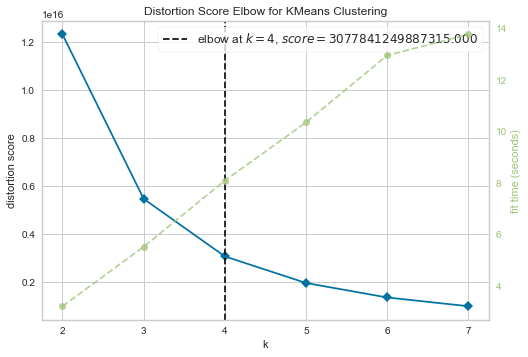

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,8))

visualizer.fit(data)
visualizer.show() 

As we can see from the plot, the elbow method tells us that the optimal number of clusters for our data is k=4.

#### Silhouette Method

In [ ]:
#We took a sample of 30,000 items from our dataset
data_sample = data.sample(30000)

The second method we used to find the optimal number of clusters for our data is silhouette method. We use the function 'silhouette_score' to compute the silhouette score for 2, 3, 4, 5, 6 and 7 clusters.

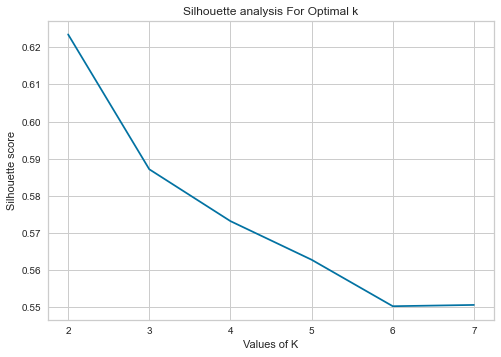

In [ ]:
clusters = [2, 3, 4, 5, 6, 7]
silhouette_avg = []

for cluster in clusters:
    kmeans=KMeans(n_clusters=cluster, random_state=42).fit(data_sample)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(data_sample, cluster_labels))
    
plt.plot(clusters,silhouette_avg,'bx-')    
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

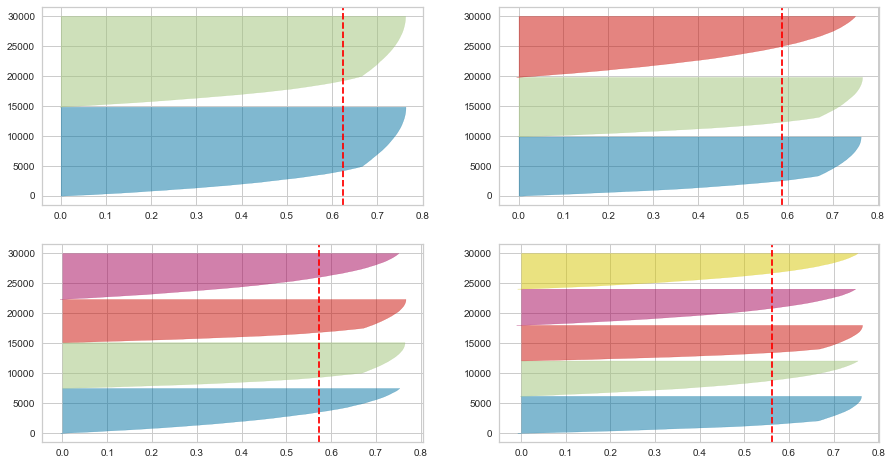

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_sample)
    cluster_labels = km.fit_predict(data_sample)
    silhouette_avg = silhouette_score(data_sample, cluster_labels)

As we can see from the plots, the silhouette method tells us that the optimal number of clusters for our data is k=2.

#### Run the already implemented version of K-means++ 

Elbow Method and Silhouette Method give us different results. We will use k=2 (the result provided by the Silhouette Method) since the elbow method calculates only the Euclidean distance while the silhouette method takes into account variables such as variance, skewness... so the silhouette score is more accurate.

We add the 'cluster' column to our dataset. For each row of the dataset this column contains the number of the cluster to which that point is assigned.

In [ ]:
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
data_sample['cluster'] = model.fit_predict(data_sample)

We plot the clusters

Text(0.5, 0, 'PC 3')

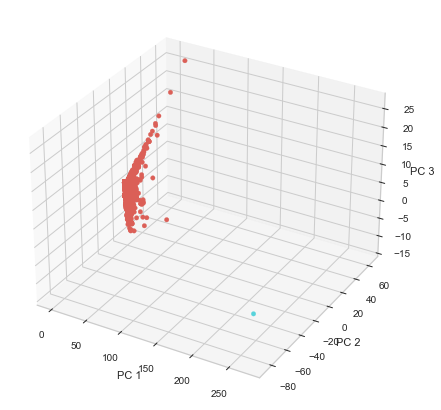

In [ ]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
unique_values = len(data_sample.cluster.unique())

cmap = ListedColormap(sns.color_palette('hls',unique_values))
sc = ax.scatter(data_sample["PC 1"], data_sample["PC 2"], data_sample["PC 3"], c=data_sample["PC 1"], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')


### 2.4 Analysing your results!

In [ ]:
#Import the variable we want to take into account
data = pd.read_csv('bank_transactions2.csv', sep=',', usecols=['Gender','Number_of_transactions', 'Numb_trans>100', 'Average_of_transactions',
                                                                                           'Average_balance', 'Utilisation', 'Max_Transaction_Amount',
                                                                                           'Min_Transaction_Amount', 'Max_Account_Balance', 
                                                                                           'Min_Account_Balance', 
                                                                                           '18<Age<60',
                                                                                           'Number_of_high_transactions', 'Number_of_low_transactions',
                                                                                           'Number_of_high_AccountBalance', 'Number_of_low_AccountBalance'
                                                                                           ])

In [ ]:
#Replace Gender with 0 if Female and 1 if Male
data = data.replace('F', 0)

In [ ]:
data = data.replace('M', 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839081 entries, 0 to 839080
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Number_of_transactions         839081 non-null  int64  
 1   Numb_trans>100                 839081 non-null  int64  
 2   Average_of_transactions        839081 non-null  float64
 3   Average_balance                839081 non-null  float64
 4   Utilisation                    839081 non-null  float64
 5   Gender                         839081 non-null  int64  
 6   Max_Transaction_Amount         839081 non-null  float64
 7   Min_Transaction_Amount         839081 non-null  float64
 8   Max_Account_Balance            839081 non-null  float64
 9   Min_Account_Balance            839081 non-null  float64
 10  18<Age<60                      839081 non-null  int64  
 11  Number_of_high_transactions    839081 non-null  int64  
 12  Number_of_low_transactions    

In [ ]:
#Standardize varibles to permorm the k-means to have the same number of clusters as before as a variable in a dataframe 
scaler = preprocessing.StandardScaler().fit(data)
data_scaled = scaler.transform(data)

In [ ]:
kmeans = KMeans(init="random", n_clusters=2)

#fit k-means algorithm to data
kmeans.fit(data_scaled)

#view cluster assignments for each observation
kmeans.labels_

array([1, 0, 1, ..., 0, 0, 0], dtype=int32)

In [ ]:
#Create an empty column to add to the dataframe
data['Cluster'] = data.apply(lambda _: '', axis=1)
data.head()

,Number_of_transactions,Numb_trans>100,Average_of_transactions,Average_balance,Utilisation,Gender,Max_Transaction_Amount,Min_Transaction_Amount,Max_Account_Balance,Min_Account_Balance,18<Age<60,Number_of_high_transactions,Number_of_low_transactions,Number_of_high_AccountBalance,Number_of_low_AccountBalance,Cluster
0,2,2,2553.0,76340.63,73787.63,1,4750.0,356.0,120180.54,32500.73,2,1,0,1,0,
1,1,1,1499.0,24204.49,22705.49,1,1499.0,1499.0,24204.49,24204.49,1,0,0,0,0,
2,2,2,727.5,100112.95,99385.45,0,1205.0,250.0,161848.76,38377.14,2,0,0,1,0,
3,1,0,30.0,496.18,466.18,0,30.0,30.0,496.18,496.18,1,0,1,0,1,
4,1,1,5000.0,87058.65,82058.65,1,5000.0,5000.0,87058.65,87058.65,1,1,0,1,0,


In [ ]:
#Fill the column with the corresponding cluster for each customer
data['Cluster'] = kmeans.labels_+1

In [ ]:
data['Cluster'].head()

0    2
1    1
2    2
3    1
4    1
Name: Cluster, dtype: int32

In [ ]:
#Counting how many customers are in each cluster
c1 = 0
c2 = 0
for i in data['Cluster']:
  if i == 1:
    c1 += 1
  else: 
    c2 += 1
print( c1, c2)
print(c1+c2)

711449 127632
839081


#### 2.4.1 Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, CustGender, Number of transactions, etc.

In [ ]:
#Select variables we think are important to identify a cluster
data1 = pd.DataFrame(data, columns=['Average_balance', 'Average_of_transactions', 'Utilisation', 'Cluster'])
data1.head()

,Average_balance,Average_of_transactions,Utilisation,Cluster
0,76340.63,2553.0,73787.63,2
1,24204.49,1499.0,22705.49,1
2,100112.95,727.5,99385.45,2
3,496.18,30.0,466.18,1
4,87058.65,5000.0,82058.65,1


#### 2.4.2 Most of your selected variables will be numerical (continuous or discrete), then categorise them into four categories.

In [ ]:
#Add a column with the respective category for each numerical variable 
data1['Categories_balance'] = pd.qcut(data1['Average_balance'], [0,0.25,0.5,0.75,1], labels=False) +1
data1['Categories_transactions'] = pd.qcut(data1['Average_of_transactions'], [0,0.25,0.5,0.75,1], labels=False) +1
data1['Categories_utilisation'] = pd.qcut(data1['Utilisation'], [0,0.25,0.5,0.75,1], labels=False) +1

In [ ]:
data1['Categories_balance'].head()

0    4
1    3
2    4
3    1
4    4
Name: Categories_balance, dtype: int64

In [ ]:
data1['Categories_transactions'].head()

0    4
1    4
2    3
3    1
4    4
Name: Categories_transactions, dtype: int64

In [ ]:
data1['Categories_utilisation'].head()

0    4
1    3
2    4
3    1
4    4
Name: Categories_utilisation, dtype: int64

In [ ]:
data1.head()

,Average_balance,Average_of_transactions,Utilisation,Cluster,Categories_balance,Categories_transactions,Categories_utilisation
0,76340.63,2553.0,73787.63,2,4,4,4
1,24204.49,1499.0,22705.49,1,3,4,3
2,100112.95,727.5,99385.45,2,4,3,4
3,496.18,30.0,466.18,1,1,1,1
4,87058.65,5000.0,82058.65,1,4,4,4


#### 2.4.3 With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

In [ ]:
#Pivot table for Average balance divided into 4 categories based on quantiles 
data1.pivot_table('Average_balance', ['Cluster'], ['Categories_balance'], aggfunc={'Categories_balance':'count'})

Categories_balance,1,2,3,4
Cluster,,,,
1,194782,176917,169680,170070
2,15000,32843,40091,39698


In [ ]:
#Pivot table for Average of transactions divided into 4 categories based on quantiles 
data1.pivot_table('Average_of_transactions', ['Cluster'], ['Categories_transactions'],aggfunc={'Categories_transactions':'count'})

Categories_transactions,1,2,3,4
Cluster,,,,
1,194472,175206,168813,172958
2,16919,33392,40509,36812


In [ ]:
#Pivot table for Utilisation divided into 4 categories based on quantiles 
data1.pivot_table('Utilisation', ['Cluster'], ['Categories_utilisation'], aggfunc={'Categories_utilisation':'count'})

Categories_utilisation,1,2,3,4
Cluster,,,,
1,194362,177131,169898,170058
2,15409,32643,39868,39712


#### 2.4.4 Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.

In [ ]:
#Pivot table for Average balance divided into 4 categories based on quantiles (values are in percentage format)
table = data1.pivot_table('Average_balance', ['Cluster'], ['Categories_balance'], aggfunc={'Categories_balance':'count'})
table[0:1] = (table[0:1]/127942)*100
table[1:2] = (table[1:2]/711139)*100
table

Categories_balance,1,2,3,4
Cluster,,,,
1,152.242422,138.279064,132.622595,132.927420
2,2.109292,4.618366,5.637576,5.582312


In [ ]:
#Pivot table for Average of transactions divided into 4 categories based on quantiles (values are in percentage format)
table = data1.pivot_table('Average_of_transactions', ['Cluster'], ['Categories_transactions'], aggfunc={'Categories_transactions':'count'})
table[0:1] = (table[0:1]/127942)*100
table[1:2] = (table[1:2]/711139)*100
table

Categories_transactions,1,2,3,4
Cluster,,,,
1,152.000125,136.941739,131.944944,135.184693
2,2.379141,4.695566,5.696355,5.176484


#### 2.4.5 Interpret the results for each pivot table.

Each value in the pivot table represents the percentage of each category of a variable in the cluster of the corresponding row. For example, in the last pivot table, 31.39% is the percentage of values of the variable 'Utilisation' which are in the third category (in our case between the second and third quartile beacuse we splitted the column values based on the quartiles) and in the first cluster. As we can easily calculate the sum of each row is 100 which means that every element of each cluster belongs to a category.

#### 2.4.6 Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?).

The silhouette Coefficient is the most popular evaluation metrics for clustering algorithms. The formula is the following one: $$s = \frac{b-a}{max(b-a)}$$ <br> where **a** is the mean distance between a sample and all other points in the same cluster while **b** is the mean distance between a sample and all other points in the next nearest cluster. <br> The score is bounded between $[-1, 1]$ where -1 means incorrect clustering and 1 means highly dense and wellseparated clusters. 0 means overlapping clusters. 

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(data, kmeans.labels_, metric='euclidean',sample_size=100000)

0.156338155533594

To evaluate the clustering we obtained, we used the silhouette score but given the dimensions of the data matrix we had to take just a sample (with size = 100000) to make it run in reasonable time. The result is not incredibly encouraging, it is bigger than zero which means our clustering goes in the right direction but there might be a little overlapping.

# Theorical Question

N = number of entrances 

M = number of students

G = number of guards 

In [ ]:
N, M, G = map(int, input().split())

 2 5 1


Ordered list containing, for each student, the number of the door through which he enters

In [ ]:
lst = list(map(int, input().split()))

 1 2 1 2 2


If the number of guards is greater or equal than the number of entrances then the output is 'YES'. There are enough guards to control all entrances.

Else I count how many students enter from each entrance and I save them in a dictionary 'd'. For each element i in the list, I count how many students enter from the entrances whose number appears between element 0 and element i (included) of the list. If for no entrance this number coincides with the one calculated previously (the values of the dictionary 'd'), it means that at least one student from all the entries considered have yet to enter. Whenever I have a new entrance on the list and students who have to enter from each of the previous entrances are not finished I assign a new guard. When the number of guards I should assign exceeds the number of guards I have available the output is 'NO'. If control remains equal to 1 it means that I have enough guards to let all the students in and so the output is 'YES'.

In [ ]:
if (G>=N):
    print('YES')
else:
    d = Counter(lst)
    control=1
    for i in range(len(lst)):
        g=0
        c=Counter(lst[:i+1])
        for k in c.keys():
            if (d[k]!=c[k]):
                g+=1
        if (g>G):
            print('NO')
            control=0
            break
    if control:
        print('YES')
        

NO
